In [1]:
import torch
from collections import namedtuple
from src.data.data import *
from src.GP.plotting import *

import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'src.data.data'

### Below is the implementation of the Kallus et al simulation

In [ ]:
data = namedtuple("data","X T Y")
outcome_funcs = namedtuple("Outcome_funcs","cfounded_func uncfounded_func")

kallus_func = lambda X,U,T,eps: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*U*X+0.5*eps


cfoundeded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*(T-0.5)*X**2
uncfounded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2

kallus_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func,
              uncfounded_func=uncfounded_func)

In [ ]:
X_range = (-3,3)
n_samples_exp = 120
n_samples_obs = 1000
T_prop=0.5

obs_data = get_obs_sample_kallus(n_samples_obs,X_range=(-1,1),T_prop=T_prop,outcome_func = kallus_func)
exp_data = get_exp_sample_kallus(n_samples_exp,X_range=(-1,1),T_prop=T_prop,outcome_func = kallus_func)

pseudo_outcome = (exp_data.T - T_prop)/((T_prop)*(1-T_prop))*exp_data.Y  
pseudo_data = data(X=exp_data.X, T=exp_data.T,Y=pseudo_outcome)


(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X'>],
       dtype=object))

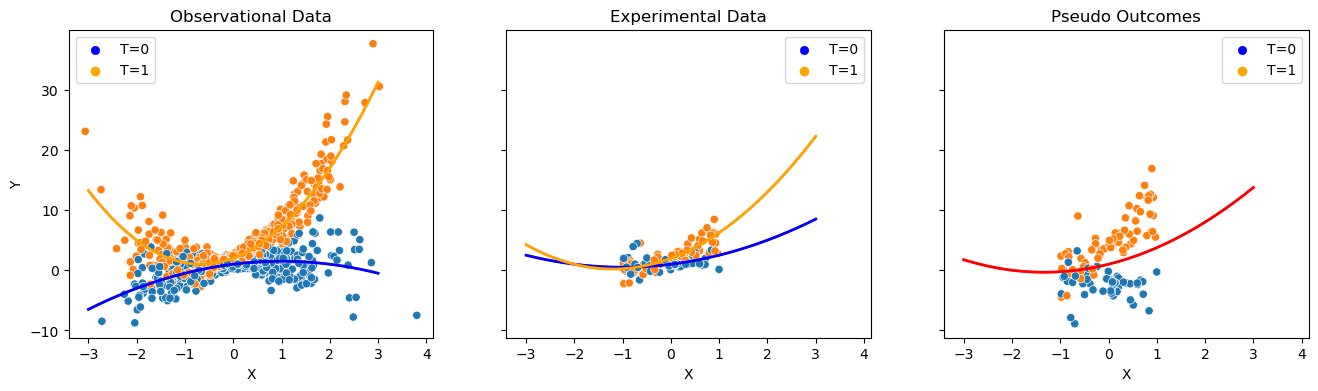

In [ ]:
obs_exp_pseudo_plot(obs_data,exp_data,kallus_outcome_funcs,T_prop=0.5)

## We now implement GP bounds following https://github.com/aCapone1/gauss_proc_unknown_hyp

In [ ]:
import gpytorch
from pyro.infer.mcmc import NUTS, MCMC
from gpytorch.priors import UniformPrior
import pyro
import pandas as pd
from src.GP_bounds import *
import numpy as np

In [ ]:
# set upper and lower bounds for uniform hyperprior
dimx = 1
ub = 1.1*torch.ones(3)
ub[0] = 1.1
ub[-1] = 1.1
lb = 0.9*torch.ones(3)
lb[-1] = 0.9
loglikelihood0 = [None]
training_iterations = 2000
num_samples = 20
warmup_steps = 20
sqrbeta0 = 1.44

hyperparam_dict = {
    "dimx":dimx,
    "ub":ub,
    "lb":lb,
    "loglikelihood0":loglikelihood0,
    "training_iterations":training_iterations,
    "num_samples":num_samples,
    "warmup_steps":warmup_steps,
    "sqrbeta0":sqrbeta0

}

In [ ]:
train_x = exp_data.X[exp_data.T==0]
train_y = exp_data.Y[exp_data.T==0]

X_plot = torch.linspace(-3, 3, 1000)
Y_plot = kallus_outcome_funcs.uncfounded_func(X_plot,0)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,_ = GP_bounds_model.bound_output(X_plot)

Training Base Model


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_37254/1528558140.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")


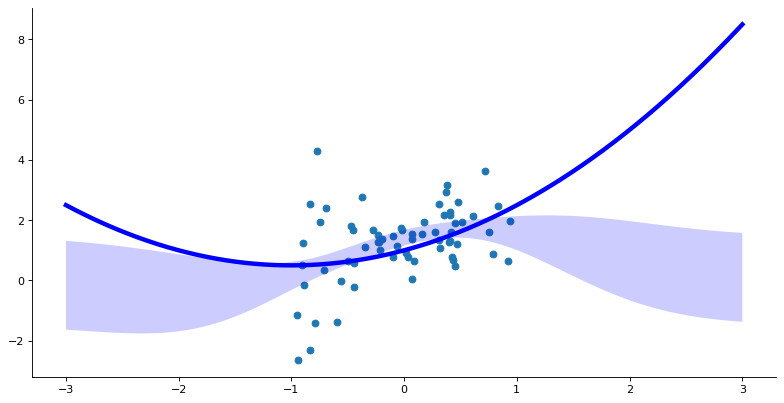

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(train_x,train_y)

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach')

## Implementing as if all functions are GP

We implement all functions as GP's to asses the benefits or failings

In [ ]:
hyperparam_dict = {
    "dimx":dimx,
    "ub":ub,
    "lb":lb,
    "loglikelihood0":loglikelihood0,
    "training_iterations":training_iterations,
    "num_samples":50,
    "warmup_steps":50,
    "sqrbeta0":1.414
}
T_prop_GP = 0.5


In [ ]:
cfd_GPs = [0,0]
ucfd_GPs = [0,0]

exp_data_GP_train = get_exp_sample_kallus(100,X_range=(-3,3),T_prop=T_prop,outcome_func = kallus_func)

adjusted_exp_data = adjust_data(exp_data_GP_train,kallus_outcome_funcs.cfounded_func)

for i in range(2):
    cfd_GPs[i] = GP_func_1d((-3,3),hyperparam_dict)
    ucfd_GPs[i] = GP_func_1d((-3,3),hyperparam_dict,train_data=get_conditioned_data(adjusted_exp_data,i),scale=1)
    # ucfd_GPs[i] = GP_func_1d((-3,3),hyperparam_dict,train_data=None,scale=1)

# cfded_GP_func = lambda X,T: (1-T)*cfd_GPs[0](X) + (T)*cfd_GPs[1](X)
cfded_GP_func = kallus_outcome_funcs.cfounded_func
ucfded_GP_func = lambda X,T: cfded_GP_func(X,T) + (1-T)*ucfd_GPs[0](X) + (T)*ucfd_GPs[1](X)
outcome_funcs_GP = outcome_funcs(cfounded_func=cfded_GP_func,uncfounded_func=ucfded_GP_func)

In [ ]:
X_range_obs = (-3,3)
X_obs = (X_range_obs[1] - X_range_obs[0]) * torch.rand(n_samples_obs) + X_range_obs[0]
T_obs = (torch.rand(n_samples_obs) > T_prop_GP).type(torch.float)
Y_obs = cfded_GP_func(X_obs,T_obs) + torch.randn(n_samples_obs)
obs_data_GP = data(X=X_obs,Y=Y_obs,T=T_obs)

X_range_exp = (-1,1)
X_exp = (X_range_exp[1] - X_range_exp[0]) * torch.rand(n_samples_exp) + X_range_exp[0]
T_exp = (torch.rand(n_samples_exp) > T_prop_GP).type(torch.float)
Y_exp = ucfded_GP_func(X_exp,T_exp) + torch.randn(n_samples_exp)
exp_data_GP = data(X=X_exp,Y=Y_exp,T=T_exp)

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X'>],
       dtype=object))

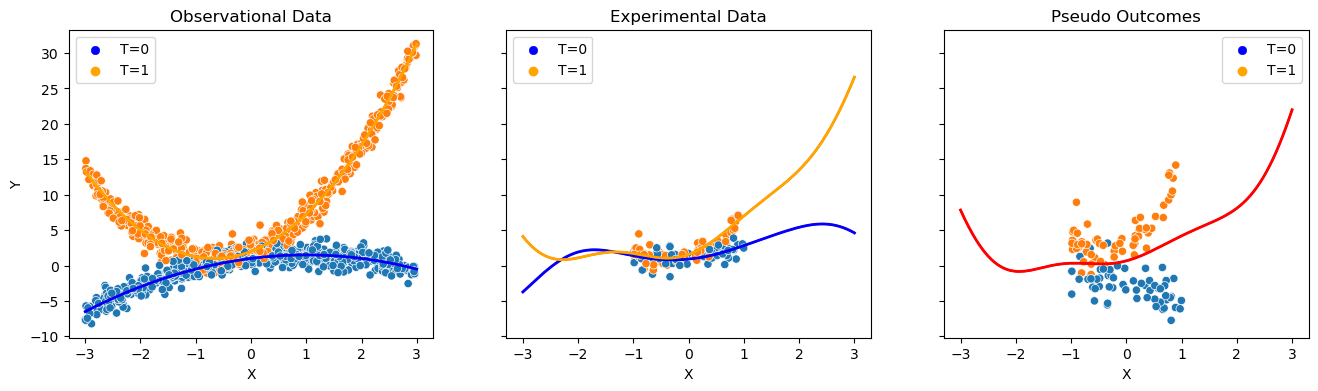

In [ ]:
obs_exp_pseudo_plot(obs_data_GP,exp_data_GP,outcome_funcs_GP,T_prop=T_prop_GP)

In [ ]:
train_x = exp_data_GP.X[exp_data_GP.T==0]
train_y = exp_data_GP.Y[exp_data_GP.T==0]

X_plot = torch.linspace(-3, 3, 1000)
Y_plot = outcome_funcs_GP.uncfounded_func(X_plot,0)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,_ = GP_bounds_model.bound_output(X_plot)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:02, 43.04it/s, step size=6.27e-01, acc. prob=0.929]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_37254/2803010479.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")


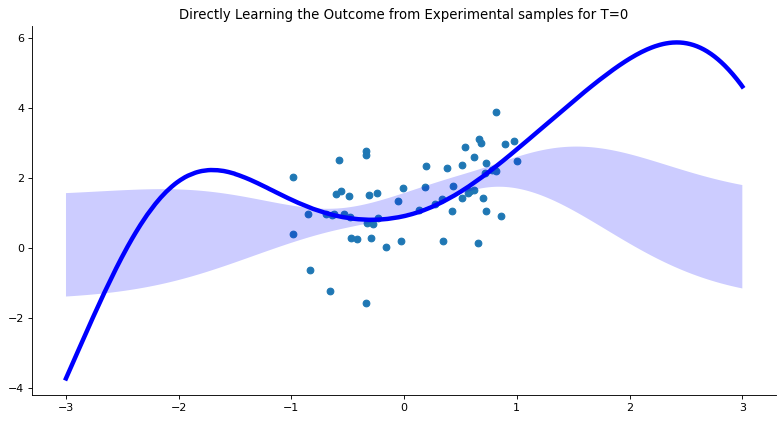

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Directly Learning the Outcome from Experimental samples for T=0")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(train_x,train_y)

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach')

In [ ]:
adjusted_exp_data_GP = adjust_data(exp_data_GP,outcome_funcs_GP.cfounded_func)

train_x = adjusted_exp_data_GP.X[adjusted_exp_data_GP.T==1]
train_y = adjusted_exp_data_GP.Y[adjusted_exp_data_GP.T==1]

X_plot = torch.linspace(-3, 3, 1000)
Y_plot =  (outcome_funcs_GP.uncfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,1))

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,stdv = GP_bounds_model.bound_output(X_plot)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:01, 52.18it/s, step size=9.65e-01, acc. prob=0.792]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_37254/1894580804.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")


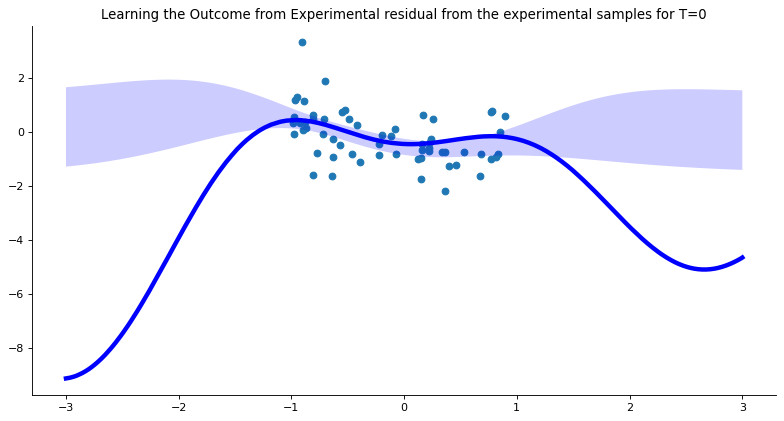

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Learning the Outcome from Experimental residual from the experimental samples for T=0")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(train_x,train_y)

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="blue")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach')

In [ ]:
adjusted_exp_data_GP = adjust_data(exp_data_GP,outcome_funcs_GP.cfounded_func)
pseudo_data_GP = get_pseudo_outcome_data(adjusted_exp_data_GP,T_prop=T_prop_GP)
train_x = pseudo_data_GP.X
train_y = pseudo_data_GP.Y

X_plot = torch.linspace(-3, 3, 1000)
# Y_plot = outcome_funcs_GP.uncfounded_func(X_plot,1)-outcome_funcs_GP.uncfounded_func(X_plot,0) - (outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0))

Y_plot = outcome_funcs_GP.uncfounded_func(X_plot,1)-outcome_funcs_GP.uncfounded_func(X_plot,0)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
mean_0 =  (outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0))
bounds,_,_ = GP_bounds_model.add_bounds(X_plot,mean_0,torch.zeros_like(stdv))

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:02, 39.81it/s, step size=7.85e-01, acc. prob=0.936]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_37254/235399475.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")


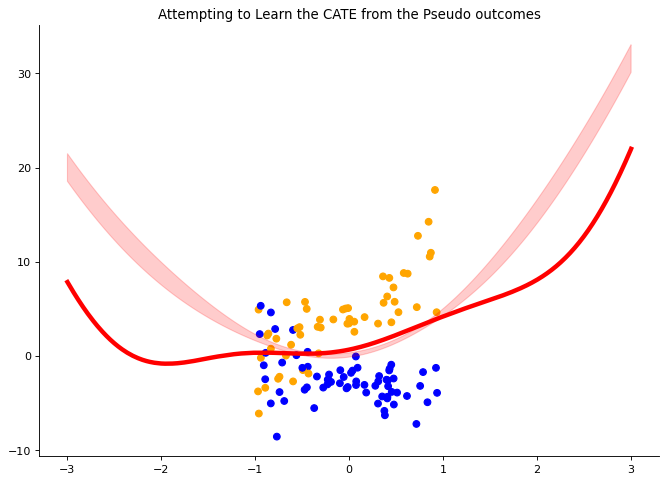

In [ ]:
colors = ["blue","orange"]
pseudo_data = get_pseudo_outcome_data(exp_data,T_prop=T_prop_GP)

fig = plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Attempting to Learn the CATE from the Pseudo outcomes")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(pseudo_data.X,pseudo_data.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach',color="red")

In [ ]:
train_x = adjusted_exp_data_GP.X[adjusted_exp_data_GP.T==0]
train_y = adjusted_exp_data_GP.Y[adjusted_exp_data_GP.T==0]


likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(lb[-1], ub[-1]),
            noise_prior=UniformPrior(lb[-1], ub[-1]))

GP_bounds_model_0 = BoundingGPModel_Unknown_Hyperparameters(likelihood,hyperparam_dict)
GP_bounds_model_0.fit(train_x,train_y)
bounds,mean_0,stdv_0 = GP_bounds_model_0.bound_output(X_plot)

mean_0 = mean_0 - (outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0))

train_x = adjusted_exp_data_GP.X[adjusted_exp_data_GP.T==1]
train_y = adjusted_exp_data_GP.Y[adjusted_exp_data_GP.T==1]

GP_bounds_model_1 = BoundingGPModel_Unknown_Hyperparameters(deepcopy(likelihood),hyperparam_dict)
GP_bounds_model.fit(train_x,train_y)
bounds,_,stdv_sum = GP_bounds_model.add_bounds(X_plot,-mean_0,stdv_0)

Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:02, 45.79it/s, step size=8.96e-01, acc. prob=0.907]


Training Base Model
Training Bayes Model
Generating GP samples for fully Bayesian GP...


Sample: 100%|██████████| 100/100 [00:01, 63.79it/s, step size=1.02e+00, acc. prob=0.730]


/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_37254/3966544334.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")


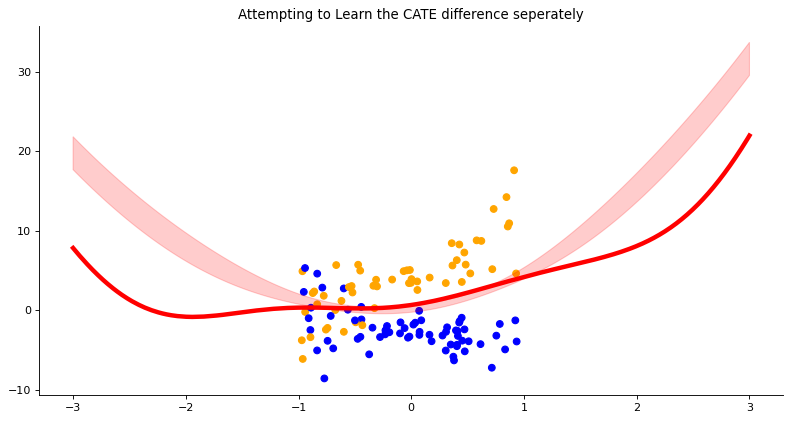

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Attempting to Learn the CATE difference seperately")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(pseudo_data.X,pseudo_data.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach',color="red")

In [ ]:
train_x0 = get_conditioned_data(adjusted_exp_data_GP,T_val=0).X
train_x1 = get_conditioned_data(adjusted_exp_data_GP,T_val=1).X

train_y0 = get_conditioned_data(adjusted_exp_data_GP,T_val=0).Y
train_y1 = get_conditioned_data(adjusted_exp_data_GP,T_val=1).Y

train_i_task1 = torch.full((train_x0.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x0, train_x1])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y0, train_y1])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

bounds,_,_ = model.bound_CATE(X_plot,sqrbeta0,add_vec=(outcome_funcs_GP.cfounded_func(X_plot,1)-outcome_funcs_GP.cfounded_func(X_plot,0)))

/Users/jfawkes/Documents/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194616/work/torch/csrc/utils/tensor_new.cpp:643.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/50 - Loss: 1.375
Iter 2/50 - Loss: 1.370
Iter 3/50 - Loss: 1.365
Iter 4/50 - Loss: 1.361
Iter 5/50 - Loss: 1.358
Iter 6/50 - Loss: 1.355
Iter 7/50 - Loss: 1.353
Iter 8/50 - Loss: 1.351
Iter 9/50 - Loss: 1.350
Iter 10/50 - Loss: 1.348
Iter 11/50 - Loss: 1.347
Iter 12/50 - Loss: 1.346
Iter 13/50 - Loss: 1.345
Iter 14/50 - Loss: 1.344
Iter 15/50 - Loss: 1.342
Iter 16/50 - Loss: 1.341
Iter 17/50 - Loss: 1.340
Iter 18/50 - Loss: 1.339
Iter 19/50 - Loss: 1.338
Iter 20/50 - Loss: 1.338
Iter 21/50 - Loss: 1.337
Iter 22/50 - Loss: 1.337
Iter 23/50 - Loss: 1.336
Iter 24/50 - Loss: 1.335
Iter 25/50 - Loss: 1.334
Iter 26/50 - Loss: 1.333
Iter 27/50 - Loss: 1.332
Iter 28/50 - Loss: 1.332
Iter 29/50 - Loss: 1.331
Iter 30/50 - Loss: 1.331
Iter 31/50 - Loss: 1.330
Iter 32/50 - Loss: 1.330
Iter 33/50 - Loss: 1.330
Iter 34/50 - Loss: 1.329
Iter 35/50 - Loss: 1.329
Iter 36/50 - Loss: 1.329
Iter 37/50 - Loss: 1.328
Iter 38/50 - Loss: 1.328
Iter 39/50 - Loss: 1.327
Iter 40/50 - Loss: 1.327
Iter 41/5

/var/folders/yr/5_cr5fgj6zj1hlf2c4zwzh9h0000gn/T/ipykernel_37254/2408539573.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")


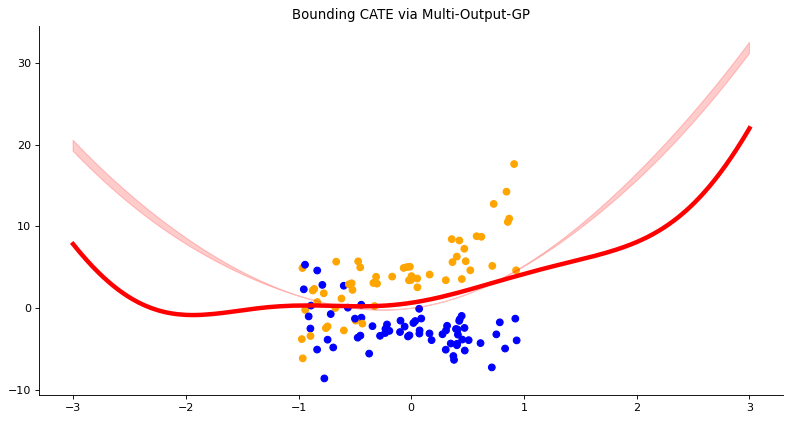

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("Bounding CATE via Multi-Output-GP")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(pseudo_data.X,pseudo_data.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_plot, 'k-', label=r'$f(x)$',linewidth=4.0,color="red")
plt.fill(torch.cat([X_plot, torch.flip(X_plot,[0])]),
            bounds,
            alpha=.2, fc='b', ec='None', label= 'Our approach',color="red")

## 